In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


selected_columns = ['Policy No',  'Renewal Type', 'Product name', 'Product name  2', 'biztype', 'Policy End Date', 'Policy Start Date', 'Reg no', 'age', 
                    'MANUFACTURER/Make', 'model', 'variant', 'Fuel Type', 'RTO Location', 'Before GST Add-on GWP',  'Total OD Premium', 'Total TP Premium',
                    'gst', 'Total Premium Payable', 'NCB % Previous Year', 'Vehicle Segment', 'Applicable Discount with NCB', 'New Branch Name  2', 'decline',
                    'Tie Up', 'Zone 2', 'state2', 'Cleaned_Insured name', 'CustomerID', 'Policy Status', 'Policy Tenure', 'Customer Tenure', 'New Customers', 
                    'Churn Label', 'Renewal Rate Status', 'Claim in last year', 'Number of Claims']

data = pd.read_excel('Actual_Data_South.xlsx')
data = data[selected_columns]

# Remove rows where 'Status' contains 'Open'
data = data[data['Policy Status'].isin(['Renewed', 'Not Renewed'])]


data['Policy Status'] = data['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('missing')
    else:
        data[column] = data[column].fillna(0)

date_columns = ['Policy Start Date', 'Policy End Date']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

# Get the most recent date in the dataset
most_recent_date = data['Policy Start Date'].max()

# Calculate the cutoff date for the last three months
months_cutoff = most_recent_date - pd.DateOffset(months=3)

# Split the data into train and test based on the cutoff date
test_data = data[data['Policy Start Date'] >= months_cutoff]
train_data = data[data['Policy Start Date'] < months_cutoff]

# Drop date columns after splitting
data = data.drop(columns=date_columns)

# Define features and target
features = [col for col in data.columns if col not in ['Policy Status']]

X_train = train_data[features]
y_train = train_data['Policy Status']

X_test = test_data[features]
y_test = test_data['Policy Status']

X_test_df = X_test.copy()

In [2]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

C:\Users\Admin\AppData\Local\Temp\ipykernel_22276\1072933455.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))
C:\Users\Admin\AppData\Local\Temp\ipykernel_22276\1072933455.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column] = X_test[column].apply(encode_test_value)
C:\Users\Admin\AppData\Local\Temp\ipykernel_22276\1072933455.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Test Accuracy: 0.9713524001829913
Test Log Loss: 0.09261121564563327
Test ROC AUC: 0.9956264616062838
Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     16671
           1       1.00      0.96      0.98     46720

    accuracy                           0.97     63391
   macro avg       0.95      0.98      0.96     63391
weighted avg       0.97      0.97      0.97     63391

Class 0 Test Accuracy: 0.9986803431107912
Class 1 Test Accuracy: 0.9616010273972603
Train Accuracy: 0.9800036651536841
Train Log Loss: 0.057685453263190085
Train ROC AUC: 0.996265575027306
Train Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    149477
           1       0.99      0.97      0.98    227042

    accuracy                           0.98    376519
   macro avg       0.98      0.98      0.98    376519
weighted avg       0.98      0.98      0.98    376519

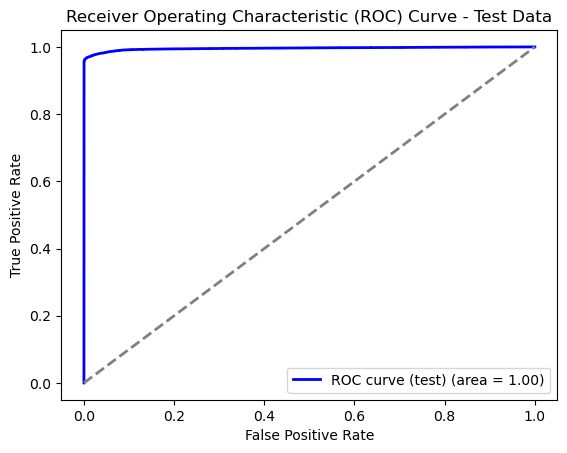

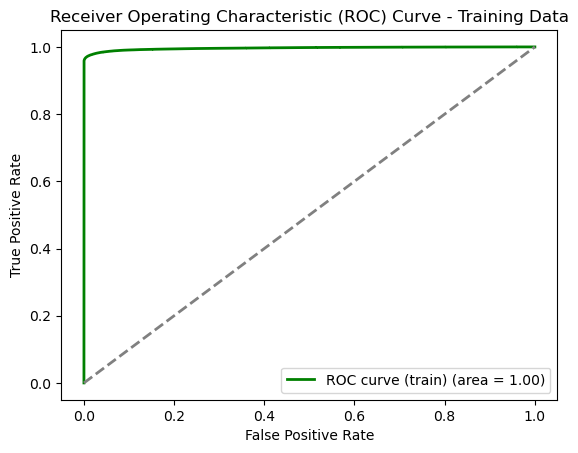

In [3]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

In [4]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

# Set up stratified k-fold cross-validation (ensuring class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and capture metrics
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=['accuracy', 'roc_auc', 'neg_log_loss'], return_train_score=True)

# Output the results of cross-validation
print("Cross-Validation Results:")
print(f"Mean Test Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Test ROC AUC: {cv_results['test_roc_auc'].mean():.4f}")
print(f"Mean Test Log Loss: {-cv_results['test_neg_log_loss'].mean():.4f}")
print(f"Mean Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"Mean Train ROC AUC: {cv_results['train_roc_auc'].mean():.4f}")
print(f"Mean Train Log Loss: {-cv_results['train_neg_log_loss'].mean():.4f}")

# Now fit the model on the entire training dataset and evaluate it
model.fit(X_train, y_train)

# Predictions and evaluation metrics as before
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Output the evaluation metrics
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Classification Report:\n{report}")

Cross-Validation Results:
Mean Test Accuracy: 0.9796
Mean Test ROC AUC: 0.9960
Mean Test Log Loss: 0.0590
Mean Train Accuracy: 0.9800
Mean Train ROC AUC: 0.9963
Mean Train Log Loss: 0.0574

Test Accuracy: 0.9714
Test Log Loss: 0.0926
Test ROC AUC: 0.9956
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     16671
           1       1.00      0.96      0.98     46720

    accuracy                           0.97     63391
   macro avg       0.95      0.98      0.96     63391
weighted avg       0.97      0.97      0.97     63391



In [5]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Reverse mapping binary values back to their original status names
def reverse_map_status(val):
    return 'Not Renewed' if val == 1 else 'Renewed'

# Apply the reverse mapping to both actual and predicted statuses
X_test_df['Actual Policy Status'] = y_test.apply(reverse_map_status).values
X_test_df['Predicted Policy Status'] = pd.Series(y_pred).apply(reverse_map_status).values

X_test_df.to_csv('test_data_with_predictions (south 24&23) wo LE.csv', index=False)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calculate the match percentage between actual and predicted statuses
matches = X_test_df[X_test_df['Actual Policy Status'] == X_test_df['Predicted Policy Status']]
match_percentage = (len(matches) / len(X_test_df)) * 100
print(f"Match Percentage: {match_percentage:.2f}%")

mismatches = X_test_df[X_test_df['Actual Policy Status'] != X_test_df['Predicted Policy Status']]
mismatches.to_csv('mismatched_results south (23&24).csv', index=False)

Accuracy: 0.97
Match Percentage: 97.14%
